In [0]:
# Import files
from __future__ import absolute_import, division, print_function

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from queue import Queue
import os

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import  train_test_split
import re

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation,Dropout,Flatten,Dense

from google.colab import files

print(tf.__version__)
from google.colab import drive
drive.mount('/content/drive')

1.14.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
"""
This code block contains methods to load and divide the dataset
"""
STEM_NAME = '250EPOCHS_RUN10_'

def loadData(series,id_num):
    pathData = "/content/drive/My Drive/ImperialMSC/Data/images{}obj{}.npy"
    pathLabels= "/content/drive/My Drive/ImperialMSC/Annotations/labels{}.npy"
    data = np.load(pathData.format(series,id_num))
    labels = np.load(pathLabels.format(id_num))
    return data,labels
  
def findIds():
    listoffiles = os.listdir('/content/drive/My Drive/ImperialMSC/Annotations')
    ids = np.zeros(len(listoffiles))
    for i,name in enumerate(listoffiles):
      ids[i] = int(re.sub("[^0-9]", "", name))
    return ids
  
def getDataIndex(test_frac,validation_frac):
    # Get dataset number_out is the number of the test series
    # validation is the size of the validation set as a fraction of the train set
    # validationset is selected randomly
    ids = findIds()
    num_traces = ids.shape[0]
    
    test_size = int(num_traces*test_frac)
    val_size = int(num_traces*validation_frac)
    
    test_ind = np.random.choice(ids,test_size,replace = False)
    test_ind = test_ind.astype('int')
    
    remaining_ind = np.array(list(set(ids)-set(test_ind)))
    val_ind = np.random.choice(remaining_ind,val_size,replace=False)
    val_ind = val_ind.astype('int')
    train_ind = np.array(list(set(remaining_ind)-set(val_ind)))
    train_ind = train_ind.astype('int')
    # Compute validation set size
    
    return train_ind, val_ind, test_ind
  
def getDataSet(indexes):
    dataSet = np.empty((1,32,32,1))
    dataLabels = np.empty(1)
    for i in indexes:
      data,labels = loadData(3,i)
      data = data[:,16:-16,16:-16,1]
      data = data/np.max(data)
      labels = np.reshape(labels,labels.shape[0])
      data = np.reshape(data,(data.shape[0],32,32,1))
      dataSet = np.append(dataSet,data,axis=0)
      dataLabels = np.append(dataLabels,labels,axis=0)
    return dataSet[1:,:,:,:],dataLabels[1:]
  
def getDataSets(test_size,validation_size):
    train_ind, val_ind, test_ind = getDataIndex(test_size,validation_size)
    np.save(STEM_NAME + 'TRAIN_IND.npy',train_ind)
    np.save(STEM_NAME + 'VAL_IND.npy',val_ind)
    np.save(STEM_NAME + 'TEST_IND.npy',test_ind)
    
    
    
    
    train_data,train_labels = getDataSet(train_ind)
    val_data,val_labels = getDataSet(val_ind)
    test_data,test_labels = getDataSet(test_ind)
    
    return train_data,val_data,test_data,train_labels,val_labels,test_labels
    
  
    

In [0]:

# GEt the datasets and make sure they have the right variable type
train_images,val_images,test_images,train_labels,val_labels,test_labels = getDataSets(0.1,0.1)
class_names = ['G1','S','G2','M']
train_labels = train_labels.astype('int32')
val_labels = val_labels.astype('int32')
test_labels = test_labels.astype('int32')




In [0]:
# Download files with indexes to be able to recreate
files.download(STEM_NAME + 'TRAIN_IND.npy')
files.download(STEM_NAME + 'VAL_IND.npy')
files.download(STEM_NAME + 'TEST_IND.npy')

In [0]:
train_images.shape[0]+test_images.shape[0] + val_images.shape[0]

6039

In [0]:
# Image data generators for data augumentation
datagen = ImageDataGenerator(
            rotation_range=40,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode = 'nearest')

datagenVal = ImageDataGenerator(rotation_range=0,
                               zoom_range=0,
                               horizontal_flip = False,
                               vertical_flip=False)

In [0]:
# Define two different models
# First a dense feed forward network
# then the full CNN model
def denseModel():
  model = Sequential([
      Flatten(input_shape=(32,32,1)),
      Dense(128,activation='relu'),
      Dense(4,activation='softmax')
  ])
  return model

def ConvModel():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=(32, 32,1)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4))
  model.add(Activation('softmax'))

  return model

In [0]:
# Set batch size and create dataset generators
batch_size = 16
train_generator = datagen.flow(train_images,train_labels,batch_size)
validation_generator = datagen.flow(val_images,val_labels,batch_size)

In [0]:
# Load and compile model
model = ConvModel()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy','categorical_accuracy'])
#model.load_weights('/content/drive/My Drive/ImperialMSC/Code/100EpochsConvolutional.h5')

In [0]:
# Summarizse model
model.summary()

W0904 09:53:39.511864 139913801738112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 09:53:39.565799 139913801738112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 09:53:39.572419 139913801738112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 09:53:39.625013 139913801738112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0904 09:53:39.678060 139913801738112 deprecation_wrapp

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)         

In [0]:
# Train the model for 250 generations
EPOCHS = 250
model.fit_generator(train_generator,
                     steps_per_epoch=2000//batch_size,
                     epochs=EPOCHS,
                     validation_data=validation_generator,
                     validation_steps=800//batch_size)


Epoch 1/250
125/125 [==============================] - 6s 47ms/step - loss: 1.1678 - acc: 0.5100 - categorical_accuracy: 0.0095 - val_loss: 1.1356 - val_acc: 0.5599 - val_categorical_accuracy: 0.0000e+00
Epoch 2/250
125/125 [==============================] - 4s 29ms/step - loss: 1.1438 - acc: 0.5010 - categorical_accuracy: 0.0160 - val_loss: 1.0820 - val_acc: 0.5751 - val_categorical_accuracy: 0.0000e+00
Epoch 3/250
125/125 [==============================] - 4s 29ms/step - loss: 1.1433 - acc: 0.4937 - categorical_accuracy: 0.0155 - val_loss: 1.0573 - val_acc: 0.5623 - val_categorical_accuracy: 0.0000e+00
Epoch 4/250
125/125 [==============================] - 4s 29ms/step - loss: 1.1171 - acc: 0.5015 - categorical_accuracy: 0.0195 - val_loss: 1.0318 - val_acc: 0.5649 - val_categorical_accuracy: 0.0000e+00
Epoch 5/250
125/125 [==============================] - 4s 29ms/step - loss: 1.0570 - acc: 0.5350 - categorical_accuracy: 0.1415 - val_loss: 1.0367 - val_acc: 0.6043 - val_categorical_a

In [0]:
# Get predictions on training set
predictions = model.predict(train_images)

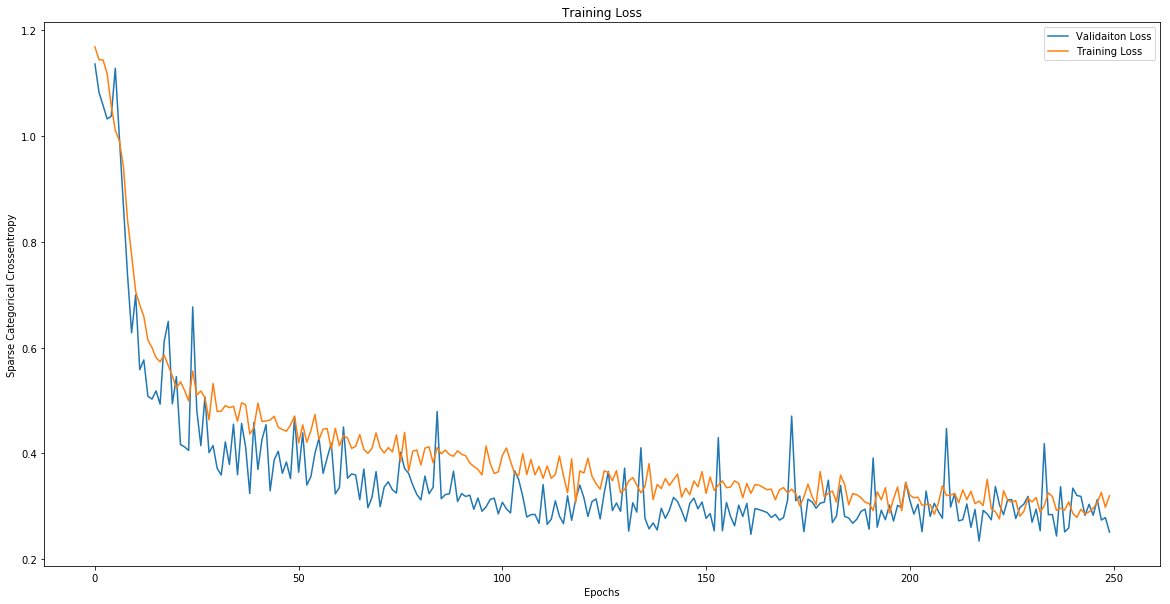

In [0]:
# Plot training and validation loss vs numer of epcochs
plt.figure(figsize=(20,10))
plt.plot(model.history.history['val_loss'],label='Validaiton Loss')
plt.plot(model.history.history['loss'],label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Sparse Categorical Crossentropy')
plt.title('Training Loss')
plt.legend()

In [0]:
# Save files with the losses
np.save(STEM_NAME+'valLoss.npy',model.history.history['val_loss'])

np.save(STEM_NAME+'loss.npy',model.history.history['loss'])

In [0]:
# Download from google colab
files.download(STEM_NAME+'valLoss.npy')
files.download(STEM_NAME+'loss.npy')

In [0]:
# Generate emission matrix report
for i in range(4):
  print("State {}".format(i))
  state_images = train_images[train_labels==i]
  preds = model.predict(state_images)
  for j in range(4):
    prop = np.sum(np.argmax(preds,axis=1)==j)/preds.shape[0]
    print("Predicted {} in {} percent of cases".format(j,prop))

State 0
Predicted 0 in 0.8937329700272479 percent of cases
Predicted 1 in 0.08446866485013624 percent of cases
Predicted 2 in 0.014986376021798364 percent of cases
Predicted 3 in 0.006811989100817439 percent of cases
State 1
Predicted 0 in 0.01992337164750958 percent of cases
Predicted 1 in 0.9773946360153257 percent of cases
Predicted 2 in 0.0026819923371647508 percent of cases
Predicted 3 in 0.0 percent of cases
State 2
Predicted 0 in 0.013888888888888888 percent of cases
Predicted 1 in 0.08012820512820513 percent of cases
Predicted 2 in 0.9027777777777778 percent of cases
Predicted 3 in 0.003205128205128205 percent of cases
State 3
Predicted 0 in 0.2198952879581152 percent of cases
Predicted 1 in 0.0 percent of cases
Predicted 2 in 0.1256544502617801 percent of cases
Predicted 3 in 0.6544502617801047 percent of cases


In [0]:
# Calculate overall accurac y
np.sum(np.argmax(predictions,axis=1)==train_labels)/predictions.shape[0]

0.9177031509121062

In [0]:

from google.colab import files

In [0]:
# Save the model weights
SAVE_NAME = 'MODEL_WEIGHTS.h5'
SAVE_NAME = STEM_NAME + SAVE_NAME
model.save_weights(SAVE_NAME)


In [0]:
files.download(SAVE_NAME)

In [0]:
# Save the model file
MODEL_SAVE_NAME = 'MODEL.h5'
MODEL_SAVE_NAME = STEM_NAME + MODEL_SAVE_NAME
model.save(MODEL_SAVE_NAME)

In [0]:
files.download(MODEL_SAVE_NAME)

AttributeError: ignored